# Setup
## Imports

In [1]:
%load_ext autoreload
%autoreload 2


In [13]:
from pathlib import Path
from generative_social_choice.utils.postprocessing import (
    collect_results_and_plot,
    plot_sorted_utility_distributions,
    plot_candidate_distribution_stacked,
    clustered_barplot_with_error_bars,
    plot_scalar_clustered_confidence_intervals,
    save_figure,
    ResultConfig,
)


## Load data

/Users/john/code/generative_social_choice/generative_social_choice/utils/postprocessing.py:334: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  row_indices.append((group_name, stat))
/Users/john/code/generative_social_choice/generative_social_choice/utils/postprocessing.py:334: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  row_indices.append((group_name, stat))
/Users/john/code/generative_social_choice/generative_social_choice/utils/postprocessing.py:1568: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


Mean  Mean of\nBottom 50%   Minimum  2*Mean Log  \
         statistic                                                          
Baseline lower bound  3.772048             3.550992  2.392773    2.644703   
         mean         3.800114             3.607574  2.547630    2.661210   
         upper bound  3.825919             3.659438  2.713318    2.676649   
Ours     lower bound  3.872061             3.754067  3.094067    2.704689   
         mean         3.882583             3.774657  3.135589    2.710443   
         upper bound  3.893194             3.795794  3.177342    2.716348   

                      Mean Log      Gini  
         statistic                        
Baseline lower bound  1.322351  0.033119  
         mean         1.330605  0.038071  
         upper bound  1.338324  0.043183  
Ours     lower bound  1.352344  0.019198  
         mean         1.355222  0.021186  
         upper bound  1.358174  0.023031

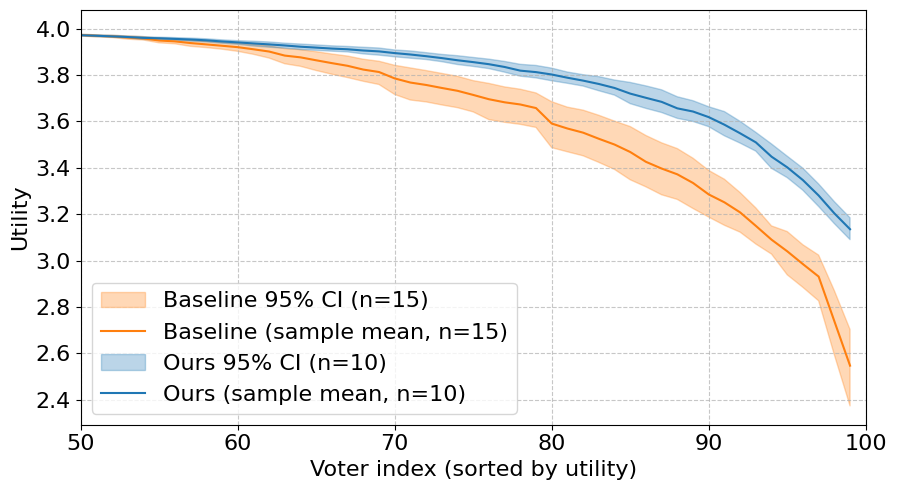

In [34]:

METHOD = "exact"
CONFIDENCE_LEVEL = .95
N_BOOTSTRAP = 400
# Figure format when saving: "png" or "pdf"
FIG_FORMAT = "pdf"
# Set to a path (e.g. "figures") to save the line plot from collect_results_and_plot; None to not save
SAVE_DIR = "figures/"

result_configs = [
    ResultConfig(
        #name="Ours (LLM Embeddings)",
        name="Ours",
        embedding_type="llm",
        run_ids=list(range(10)),
    ),
    #ResultConfig(
    #    name="Ours (Fish Embeddings)",
    #    embedding_type="fish",
    #    run_ids=[f"fish_{i}" for i in range(10)],
    #),
    #ResultConfig(
    #    name="Baseline (LLM Embeddings)",
    #    embedding_type="seed_statement",
    #    run_ids=range(15),
    #    pipeline="fish",
    #),
    ResultConfig(
        name="Baseline",
        embedding_type="llm",
        run_ids=range(15),
        pipeline="fish",
    )
]

results = collect_results_and_plot(
    result_configs, method=METHOD, confidence_level=CONFIDENCE_LEVEL, n_bootstrap=N_BOOTSTRAP,
    save_dir=SAVE_DIR, fig_format=FIG_FORMAT, figsize=(9, 5),
)

results["scalar_confidence_intervals"]

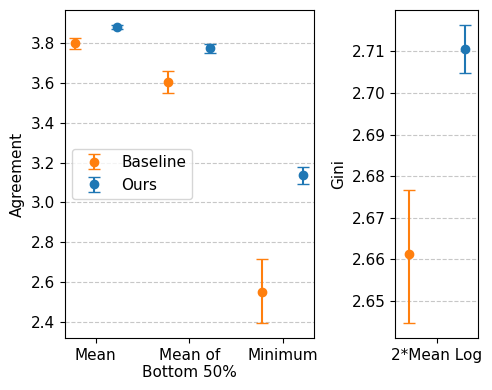

In [ ]:
scalar_confidence_intervals_plot = plot_scalar_clustered_confidence_intervals(
    results["scalar_confidence_intervals"].iloc[:,:3],
    y_label="Agreement",
    legend_loc="center left",
    fig_size=(5, 4),
    secondary_axis_df=results["scalar_confidence_intervals"].iloc[:,[3]],
    secondary_y_label="Gini",
    font_size=12
)
if SAVE_DIR:
    save_figure(scalar_confidence_intervals_plot, Path(SAVE_DIR) / "scalar_confidence_intervals", FIG_FORMAT)

/Users/john/code/generative_social_choice/generative_social_choice/utils/postprocessing.py:334: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  row_indices.append((group_name, stat))
/Users/john/code/generative_social_choice/generative_social_choice/utils/postprocessing.py:334: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  row_indices.append((group_name, stat))
/Users/john/code/generative_social_choice/generative_social_choice/utils/postprocessing.py:1568: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


Mean  Mean of\nBottom 50%   Minimum  \
                       statistic                                              
Baseline (LLM Embs.)   lower bound  3.788535             3.584290  2.403826   
                       mean         3.812595             3.632407  2.617705   
                       upper bound  3.832871             3.673184  2.820136   
Baseline (Their Embs.) lower bound  3.776908             3.560849  2.402485   
                       mean         3.800114             3.607574  2.547630   
                       upper bound  3.820545             3.648656  2.692201   
Ours (LLM Embs.)       lower bound  3.871456             3.752643  3.088648   
                       mean         3.882583             3.774657  3.135589   
                       upper bound  3.894268             3.797914  3.178251   
Ours (Their Embs.)     lower bound  3.868425             3.747142  2.993573   
                       mean         3.875037             3.759778  3.083552   
                       upper bound  3.880679             3.770494  3.163876   

                                    2*Mean Log  Mean Log      Gini  
                       statistic                                    
Baseline (LLM Embs.)   lower bound    2.653926  1.326963  0.031854  
                       mean           2.668549  1.334274  0.035974  
                       upper bound    2.681083  1.340541  0.040641  
Baseline (Their Embs.) lower bound    2.647390  1.323695  0.034007  
                       mean           2.661210  1.330605  0.038071  
                       upper bound    2.673572  1.336786  0.042457  
Ours (LLM Embs.)       lower bound    2.704286  1.352143  0.019095  
                       mean           2.710443  1.355222  0.021186  
                       upper bound    2.716891  1.358446  0.023255  
Ours (Their Embs.)     lower bound    2.702710  1.351355  0.021481  
                       mean           2.706384  1.353192  0.022451  
                       upper bound    2.709582  1.354791  0.023628

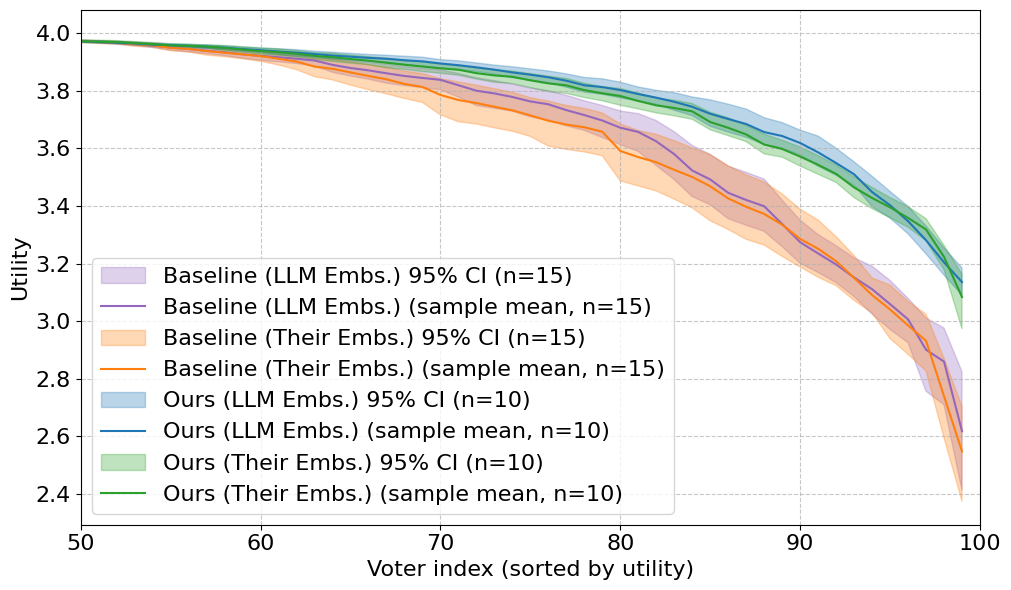

In [27]:

METHOD = "exact"
CONFIDENCE_LEVEL = .95
N_BOOTSTRAP = 400
# Figure format when saving: "png" or "pdf"
FIG_FORMAT = "pdf"
# Set to a path (e.g. "figures") to save the line plot from collect_results_and_plot; None to not save
SAVE_DIR = "figures/"

result_configs = [
    ResultConfig(
        name="Ours (LLM Embs.)",
        #name="Ours",
        embedding_type="llm",
        run_ids=list(range(10)),
    ),
    ResultConfig(
        name="Ours (Their Embs.)",
        embedding_type="fish",
        run_ids=[f"fish_{i}" for i in range(10)],
    ),
    ResultConfig(
        name="Baseline (LLM Embs.)",
        embedding_type="seed_statement",
        run_ids=range(15),
        pipeline="fish",
    ),
    ResultConfig(
        name="Baseline (Their Embs.)",
        embedding_type="llm",
        run_ids=range(15),
        pipeline="fish",
    )
]

results = collect_results_and_plot(
    result_configs, method=METHOD, confidence_level=CONFIDENCE_LEVEL, n_bootstrap=N_BOOTSTRAP,
    save_dir=SAVE_DIR, fig_format=FIG_FORMAT, figsize=(10, 6),
)

results["scalar_confidence_intervals"]

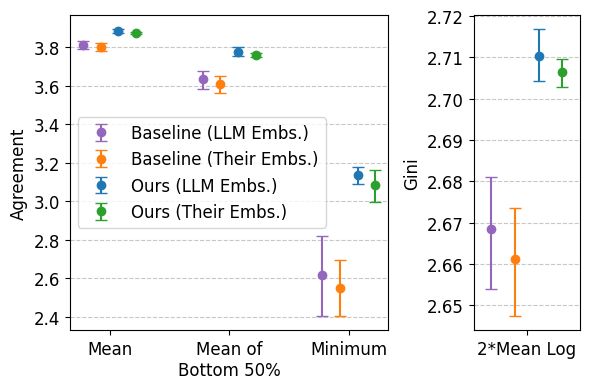

In [32]:
scalar_confidence_intervals_plot = plot_scalar_clustered_confidence_intervals(
    results["scalar_confidence_intervals"].iloc[:,:3],
    y_label="Agreement",
    legend_loc="center left",
    fig_size=(6, 4),
    secondary_axis_df=results["scalar_confidence_intervals"].iloc[:,[3]],
    secondary_y_label="Gini",
    font_size=12
)
if SAVE_DIR:
    save_figure(scalar_confidence_intervals_plot, Path(SAVE_DIR) / "scalar_confidence_intervals_all", FIG_FORMAT)

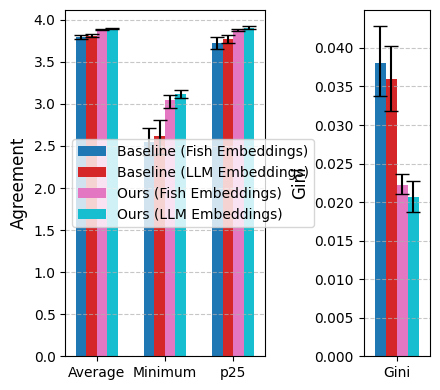

In [6]:
scalar_confidence_intervals_plot = clustered_barplot_with_error_bars(
    results["scalar_confidence_intervals"].iloc[:,:3],
    y_label="Agreement",
    legend_loc="center left",
    fig_size=(4.5, 4),
    secondary_axis_df=results["scalar_confidence_intervals"].iloc[:,[3]],
    secondary_y_label="Gini"
)

### Older Plots

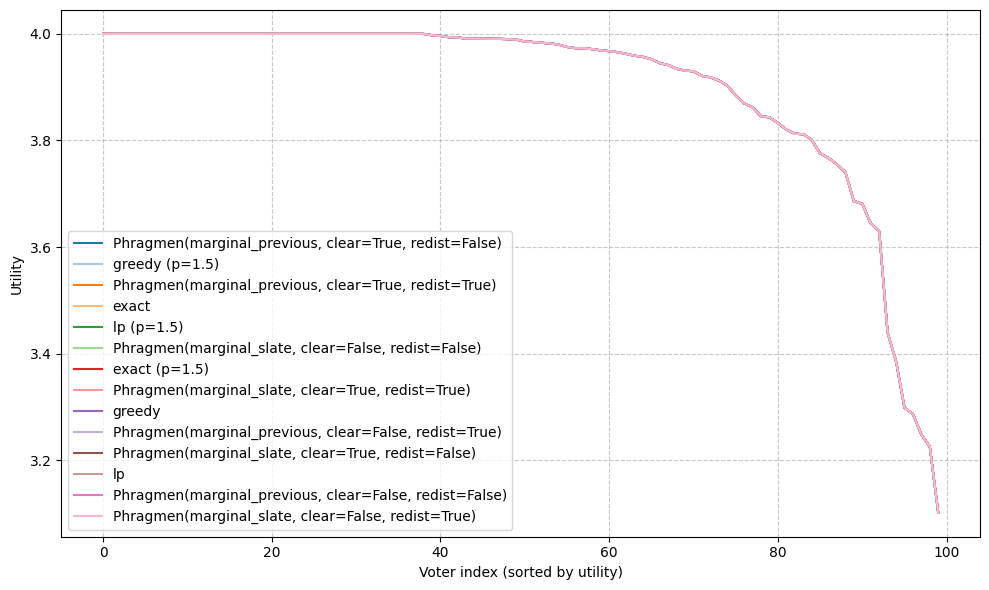

In [7]:
fig = plot_sorted_utility_distributions(results["utility_df_dict"]["Ours (LLM Embeddings)"][0])
if SAVE_DIR:
    save_figure(fig, Path(SAVE_DIR) / "sorted_utility_distributions", FIG_FORMAT)

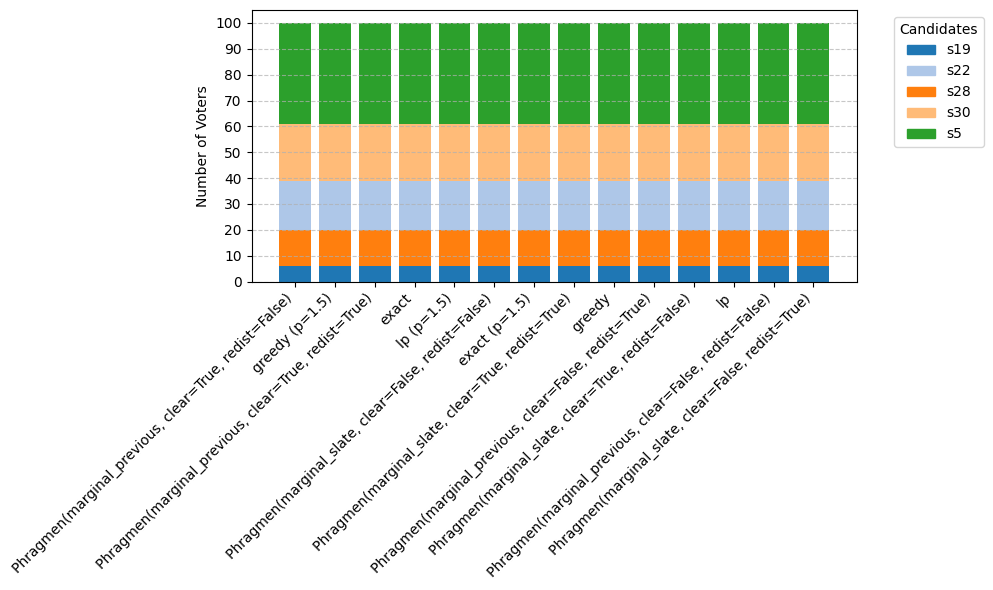

In [8]:
fig = plot_candidate_distribution_stacked(results["algo_assignments"]["Ours (LLM Embeddings)"][0])